In [203]:
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

In [204]:
# Load raw data from stocks and find anomalies inside it using pandas

In [205]:
# Load data
dataset = "data_live"
df = pd.read_csv(f"data/{dataset}.csv")
columns = ["price", "volume", "trade_ts", "ingestion_ts", "uuid"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
# df = df[columns]
df["trade_ts"] = df["trade_ts"].apply(lambda a: datetime.strptime(a, timestamp_format))
df['trade_ts'] = pd.to_datetime(df["trade_ts"], format=timestamp_format)
# df = df.set_index("trade_ts")

threshold_prices = [3]
threshold_volumes = [1.5]
window_sizes_prices = [7]
window_sizes_volumes = [7]

In [206]:
def find_anomalies_pandas_time(input_df: pd.DataFrame, thresholds: list, 
                               column_name: str, window_sizes: list) -> pd.DataFrame:
    """
    Detect anomalies in the specified column (e.g., 'is_price') using MAD-based z-score logic for different thresholds 
    and window sizes in seconds. Anomalies are marked in the 'is_anomaly_price' column.
    :param input_df: Pandas DataFrame containing the input data
    :param thresholds: List of thresholds for anomaly detection
    :param column_name: Column to check anomalies for (e.g., 'is_price')
    :param window_sizes: List of window sizes (in seconds)
    :return: Pandas DataFrame with anomalies marked in the 'is_anomaly_price' column
    """
    # Add a new column for anomaly detection, initialized to 0 (non-anomalous)
    input_df['is_anomaly_price'] = 0
    input_df['trade_ts'] = pd.to_datetime(input_df['trade_ts'])

    for window_size in window_sizes:
        # Convert window size from seconds to a timedelta
        window_timedelta = timedelta(seconds=window_size)

        # Sort by timestamp for rolling window calculations
        input_df = input_df.sort_values('trade_ts').reset_index(drop=True)

        # Rolling window using time spans to compute median and MAD
        input_df['rolling_median'] = (
            input_df
            .rolling(window=window_timedelta, on='trade_ts')[column_name]
            .median()
        )
        input_df['absolute_deviation'] = abs(input_df[column_name] - input_df['rolling_median'])
        input_df['rolling_mad'] = (
            input_df
            .rolling(window=window_timedelta, on='trade_ts')['absolute_deviation']
            .median()
        )

        for threshold in thresholds:
            # Compute z-scores using MAD
            input_df['z_score'] = input_df['absolute_deviation'] / (input_df['rolling_mad'] + 1e-9)
            
            # Mark anomalies in 'is_anomaly_price' column
            input_df.loc[input_df['z_score'] > threshold, 'is_anomaly_price'] = 1

    return input_df

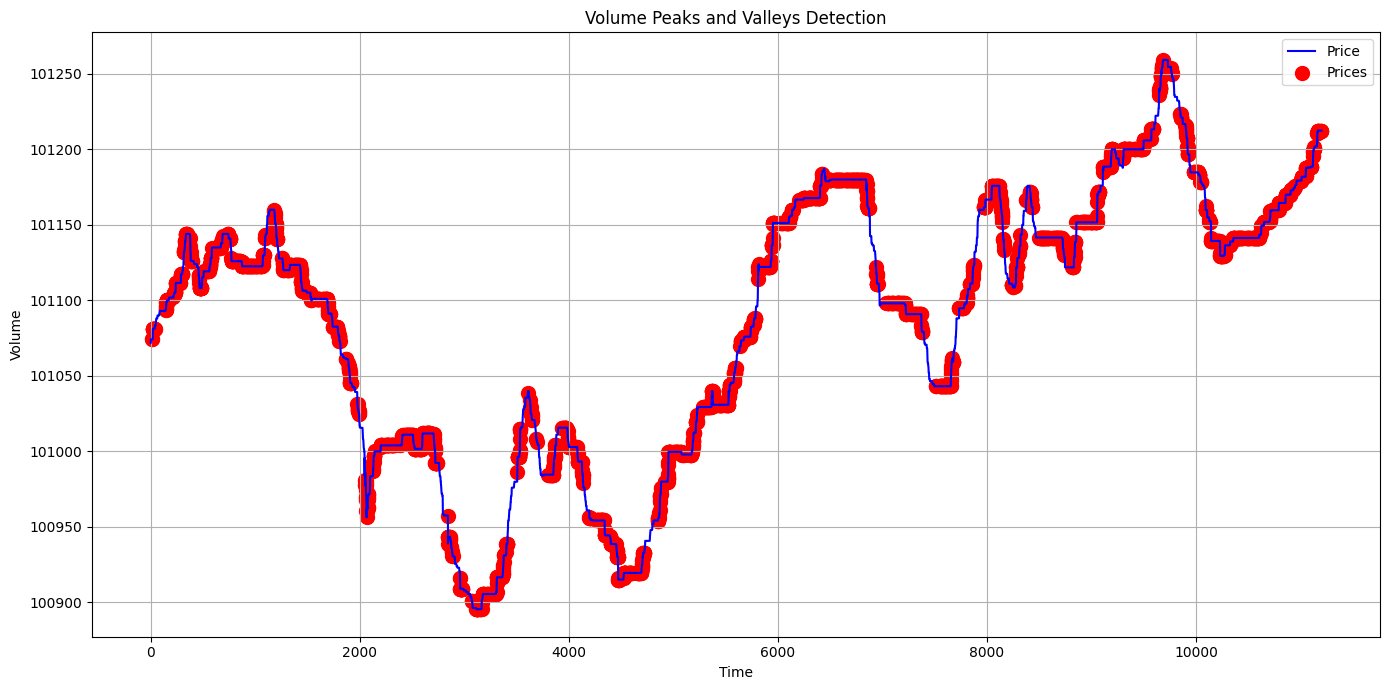

Price anomalies:
                 symbol                         trade_ts  \
13     BINANCE:BTCUSDT 2024-12-14 22:02:04.591000+00:00   
16     BINANCE:BTCUSDT 2024-12-14 22:02:05.839000+00:00   
20     BINANCE:BTCUSDT 2024-12-14 22:02:06.122000+00:00   
21     BINANCE:BTCUSDT 2024-12-14 22:02:06.381000+00:00   
22     BINANCE:BTCUSDT 2024-12-14 22:02:07.137000+00:00   
...                ...                              ...   
11186  BINANCE:BTCUSDT 2024-12-14 22:52:15.217000+00:00   
11191  BINANCE:BTCUSDT 2024-12-14 22:52:17.169000+00:00   
11194  BINANCE:BTCUSDT 2024-12-14 22:52:17.395000+00:00   
11195  BINANCE:BTCUSDT 2024-12-14 22:52:17.670000+00:00   
11196  BINANCE:BTCUSDT 2024-12-14 22:52:17.688000+00:00   

                       ingestion_ts      price  trade_conditions   type  \
13     2024-12-14 22:02:27.894+0000  101074.16               NaN  trade   
16     2024-12-14 22:02:27.894+0000  101074.16               NaN  trade   
20     2024-12-14 22:02:27.894+0000  101080.78  

In [207]:
prices_df = find_anomalies_pandas_time(df, threshold_prices, "price", window_sizes_prices)

plt.figure(figsize=(14, 7))
plt.plot(prices_df.index, prices_df['price'], label='Price', color='blue', linewidth=1.5)
plt.scatter(prices_df.index[prices_df['is_anomaly_price'] == 1], 
            prices_df['price'][prices_df['is_anomaly_price'] == 1], 
            label='Prices', color='red', s=100)

plt.title("Volume Peaks and Valleys Detection")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Price anomalies:\n", prices_df[prices_df['is_anomaly_price'] == 1])


In [208]:

def detect_peaks_and_valleys(input_df, window_size, column, timestamp_column='timestamp', 
                              prominence_peaks=50, prominence_valleys=50):
    # Ensure the timestamp column is in datetime format
    input_df[timestamp_column] = pd.to_datetime(input_df[timestamp_column])
    
    # Window size in seconds (assume window_size is provided in seconds)
    window_size_timedelta = pd.Timedelta(seconds=window_size)
    
    # Initialize columns for peak and valley anomalies
    input_df['peak_anomaly'] = 0
    input_df['valley_anomaly'] = 0
    
    # Loop over the DataFrame, checking for anomalies within each time window
    for i in range(len(input_df)):
        start_time = input_df[timestamp_column].iloc[i] - window_size_timedelta
        end_time = input_df[timestamp_column].iloc[i] + window_size_timedelta
        
        # Filter data for the current window
        window_df = input_df[(input_df[timestamp_column] >= start_time) & (input_df[timestamp_column] <= end_time)]
        
        # Find peaks and valleys within the window
        peaks, _ = find_peaks(window_df[column], prominence=prominence_peaks)
        inverted_column = -window_df[column]
        valleys, _ = find_peaks(inverted_column, prominence=prominence_valleys)
        
        # Set peak and valley anomalies
        input_df.loc[window_df.index[peaks], 'peak_anomaly'] = 1
        input_df.loc[window_df.index[valleys], 'valley_anomaly'] = 1
    
    return input_df

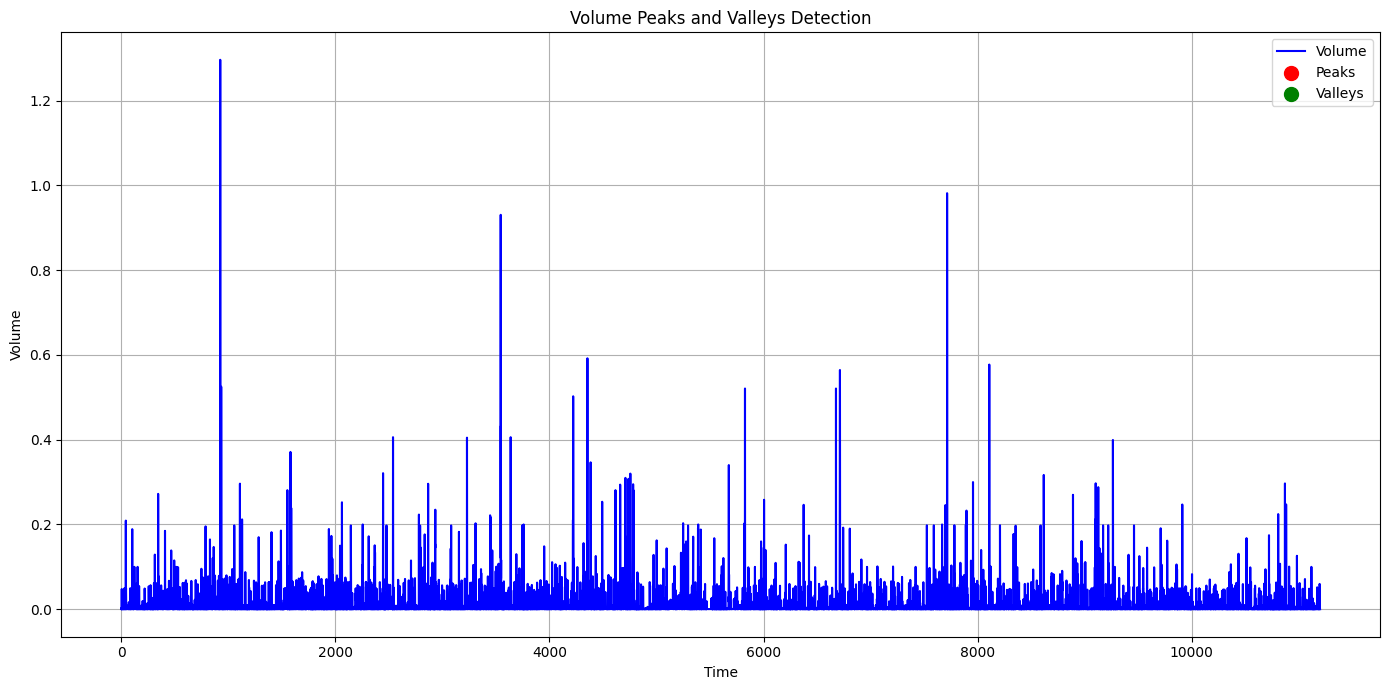

Peaks:
 Empty DataFrame
Columns: [symbol, trade_ts, ingestion_ts, price, trade_conditions, type, uuid, volume, is_anomaly_price, peak_anomaly, valley_anomaly]
Index: []
Valleys:
 Empty DataFrame
Columns: [symbol, trade_ts, ingestion_ts, price, trade_conditions, type, uuid, volume, is_anomaly_price, peak_anomaly, valley_anomaly]
Index: []


In [209]:
volume_df = detect_peaks_and_valleys(df, window_sizes_volumes[0], column='volume', 
                                     timestamp_column="trade_ts", prominence_peaks=1.5, prominence_valleys=1.5)

plt.figure(figsize=(14, 7))
plt.plot(volume_df.index, volume_df['volume'], label='Volume', color='blue', linewidth=1.5)
plt.scatter(volume_df.index[volume_df['peak_anomaly'] == 1], 
            volume_df['volume'][volume_df['peak_anomaly'] == 1], 
            label='Peaks', color='red', s=100)
plt.scatter(volume_df.index[volume_df['valley_anomaly'] == 1], 
            volume_df['volume'][volume_df['valley_anomaly'] == 1], 
            label='Valleys', color='green', s=100)
plt.title("Volume Peaks and Valleys Detection")
plt.xlabel("Time")
plt.ylabel("Volume")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

print("Peaks:\n", volume_df[volume_df['peak_anomaly'] == 1])
print("Valleys:\n", volume_df[volume_df['valley_anomaly'] == 1])

# Comparing the results

In [210]:
# Preprocess pandas df with anomalies detected ex post
pandas_df = pd.merge(prices_df, volume_df, on=["uuid", "ingestion_ts","symbol", "trade_ts", "price", "volume"], how="inner")

pandas_df["is_anomaly"] = ((pandas_df["is_anomaly_price_x"] == 1) 
                                    | (pandas_df["peak_anomaly"] == 1) | (pandas_df["valley_anomaly"] == 1))
columns_to_remove = ['is_anomaly_price_x', 'rolling_median',
       'absolute_deviation', 'rolling_mad', 'z_score', 'trade_conditions_y', 'trade_conditions_x', 'type_x',
       'type_y', 'is_anomaly_price_y', 'peak_anomaly', 'valley_anomaly']
pandas_df = pandas_df.drop(columns=columns_to_remove)



In [211]:
# Read again all data points
dataset = "data_live"
all_data_points = pd.read_csv(f"data/{dataset}.csv")
all_data_points_columns = ["price", "volume", "trade_ts", "ingestion_ts", "symbol"]
timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
all_data_points = all_data_points[all_data_points_columns]
datetime_columns = ["trade_ts", "ingestion_ts"]
for column in datetime_columns:
    all_data_points[column] = all_data_points[column].apply(lambda a: datetime.strptime(a, timestamp_format))
    all_data_points[column] = pd.to_datetime(all_data_points[column], format=timestamp_format)

# Floor trade_ts to the nearest second
all_data_points['trade_ts_rounded'] = all_data_points['trade_ts'].dt.floor('s')
all_data_points['ingestion_ts_rounded'] = all_data_points['ingestion_ts'].dt.floor('s')

# Group by the floored timestamp
grouped_df = all_data_points.groupby('trade_ts_rounded').agg({
    'price': 'mean',  # Example aggregation
    'volume': 'sum',  # Example aggregation
})
grouped_df["symbol"] = all_data_points["symbol"]
grouped_df["ingestion_ts_rounded"] = all_data_points["ingestion_ts_rounded"]
# Reset index if needed
grouped_df = grouped_df.reset_index()



In [212]:
# Load anomalies from spark and merge it with stocks to get results from system
anomaly_dataset = "anomalies_live.csv"
anomalies_df_raw = pd.read_csv(f"data/{anomaly_dataset}")
anomalies_columns = ["price", "volume", "trade_ts", "ingestion_ts", "symbol"]

anomalies_df_raw = anomalies_df_raw[anomalies_columns]

# Mark every row as anomaly
anomalies_df_raw["is_anomaly"] = 1

timestamp_format = "%Y-%m-%d %H:%M:%S.%f%z"
datetime_columns = ["trade_ts", "ingestion_ts"]
for column in datetime_columns:
    anomalies_df_raw[column] = anomalies_df_raw[column].apply(lambda a: datetime.strptime(a, timestamp_format))
    anomalies_df_raw[column] = pd.to_datetime(anomalies_df_raw[column], format=timestamp_format)

# Floor trade_ts to the nearest second
anomalies_df_raw['trade_ts_rounded'] = anomalies_df_raw['trade_ts'].dt.floor('s')
anomalies_df_raw['ingestion_ts_rounded'] = anomalies_df_raw['ingestion_ts'].dt.floor('s')

# Group by the floored timestamp
anomaly_grouped_df = anomalies_df_raw.groupby('trade_ts_rounded').agg({
    'price': 'mean',  # Example aggregation
    'volume': 'sum',  # Example aggregation
    'is_anomaly': 'max',  # 1 if any row in the group has 1
})
anomaly_grouped_df["symbol"] = anomalies_df_raw["symbol"]
anomaly_grouped_df["ingestion_ts_rounded"] = anomalies_df_raw["ingestion_ts_rounded"]


# Reset index if needed
anomaly_grouped_df = anomaly_grouped_df.reset_index()


In [213]:
# Create sets to check which column is buggy --> uuid
column_to_check = ["trade_ts_rounded", "ingestion_ts_rounded", "symbol", "price", "volume"]
sec_df = set(anomaly_grouped_df[column_to_check])
diff = sec_df - set(grouped_df[column_to_check])
print(f"There are {len(diff)} diffs")

There are 0 diffs


In [214]:
# TODO fix merge
# Perform merge
merge_keys = ["symbol", "price", "volume"]

merged_df = pd.merge(grouped_df, anomaly_grouped_df, on=merge_keys, how='inner')
print(f"There are {len(merged_df[merged_df['is_anomaly'] == 1])} anomalies in Spark after merging")

merged_df["is_anomaly"] = merged_df["is_anomaly"].fillna(0)
print(merged_df.columns)


There are 104 anomalies in Spark after merging
Index(['trade_ts_rounded_x', 'price', 'volume', 'symbol',
       'ingestion_ts_rounded_x', 'trade_ts_rounded_y', 'is_anomaly',
       'ingestion_ts_rounded_y'],
      dtype='object')


In [215]:
print(merged_df.describe())
print(merged_df.info)

               price      volume  is_anomaly
count     104.000000  104.000000       104.0
mean   101098.103755    0.017247         1.0
std        93.252835    0.026241         0.0
min    100896.385000    0.000050         1.0
25%    101023.732375    0.000830         1.0
50%    101116.785833    0.004955         1.0
75%    101162.364583    0.015437         1.0
max    101259.243333    0.115780         1.0
<bound method DataFrame.info of            trade_ts_rounded_x          price   volume symbol  \
0   2024-12-14 22:03:39+00:00  101119.218000  0.01071    NaN   
1   2024-12-14 22:03:40+00:00  101119.210000  0.00445    NaN   
2   2024-12-14 22:03:41+00:00  101119.217500  0.01178    NaN   
3   2024-12-14 22:04:22+00:00  101140.956000  0.00695    NaN   
4   2024-12-14 22:04:23+00:00  101140.950000  0.03440    NaN   
..                        ...            ...      ...    ...   
99  2024-12-14 22:50:13+00:00  101164.463333  0.00507    NaN   
100 2024-12-14 22:51:03+00:00  101172.840000  0.002

KeyError: 'trade_ts'

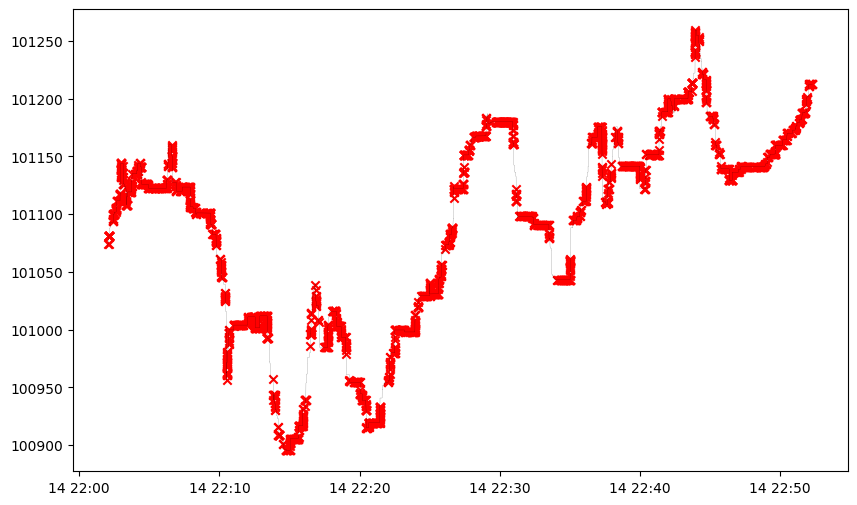

In [217]:
# Plotting compare
plt.figure(figsize=(10, 6))

# Change after fixing merge
base_df = pandas_df.copy()
first_df_anomalies = pandas_df[pandas_df['is_anomaly'] == 1].copy()
second_df_anomalies = merged_df[merged_df['is_anomaly'] == 1].copy()

# Plot all points from the first dataframe
plt.plot(base_df['trade_ts'], base_df['price'], label='All points', color='black', linewidth=0.1)

# # Plot anomalies from the first dataframe (is_anomaly_price == 1)
plt.scatter(first_df_anomalies['trade_ts'], 
            first_df_anomalies['price'], 
            label='Anomalies from Pandas', color='red', marker='x')

# Plot anomalies from the second dataframe
plt.scatter(second_df_anomalies['trade_ts'], 
            second_df_anomalies['price'], 
            label='Anomalies from Spark', color='green', marker='o')

# Customize plot
plt.title('Price Anomalies Plot')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In [ ]:
# TODO Do the same for volume
